Predicting the Weather with Neural Networks
===========================================


Example neural network

![title](img/ANN_with_number.png)

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

Read a CSV data file.


`MinTemp`, `MaxTemp`, `Temp9am`, `Temp3pm`: Temperature readings are fundamental to weather. The daily range and specific temperature points help define the conditions for rain.\
`Rainfall`: The amount of rain that fell on the current day. This is a very strong indicator; a rainy day might be followed by another.\
`Evaporation`, `Sunshine`: These measure the sun's effect. High sunshine and evaporation suggest clear, dry conditions, making rain less likely.\
`WindGustDir`, `WindDir9am`, `WindDir3pm`: Wind direction tells the model where the air is coming from (e.g., a moist ocean or a dry desert). The script correctly transforms this cyclical data into sine and cosine values.\
`WindGustSpeed`, `WindSpeed9am`, `WindSpeed3pm`: Wind speed is important because weather systems move with the wind. High winds can bring in new weather fronts quickly.\
`Humidity9am`, `Humidity3pm`: This is one of the most critical features. Humidity is a direct measure of the amount of moisture in the air, which is a necessary ingredient for rain.\
`Pressure9am`, `Pressure3pm`: Atmospheric pressure is a classic weather predictor. Low-pressure systems are strongly associated with clouds and precipitation.\
`Cloud9am`, `Cloud3pm`: The amount of cloud cover. This is also a critical feature, as we can't have rain without clouds.
RainToday: A simple 'Yes' or 'No' for rain on the current day. It's a powerful, direct summary of the day's weather.


In [2]:
df = pd.read_csv("weatherPerth.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-07-01,Perth,2.7,18.8,0.0,0.8,9.1,ENE,20.0,NaN,...,53.0,1027.6,1024.5,2.0,3.0,8.5,18.1,No,0.0,No
1,2008-07-02,Perth,6.4,20.7,0.0,1.8,7.0,NE,22.0,ESE,...,39.0,1024.1,1019.0,0.0,6.0,11.1,19.7,No,0.4,No
2,2008-07-03,Perth,6.5,19.9,0.4,2.2,7.3,NE,31.0,NaN,...,71.0,1016.8,1015.6,1.0,3.0,12.1,17.7,No,1.8,Yes
3,2008-07-04,Perth,9.5,19.2,1.8,1.2,4.7,W,26.0,NNE,...,73.0,1019.3,1018.4,6.0,6.0,13.2,17.7,Yes,1.8,Yes
4,2008-07-05,Perth,9.5,16.4,1.8,1.4,4.9,WSW,44.0,W,...,57.0,1020.4,1022.1,7.0,5.0,15.9,16.0,Yes,6.8,Yes


**Data Scoping: Focusing the Analysis**

To create a specialized and more accurate local weather model, we will focus our analysis on a single location: **Perth**. This simplifies the problem by removing regional variations that a more complex model would need to account for. After filtering the data for Perth, the `Location` column will be constant and can be removed.

In [ ]:
# Filter the DataFrame to include only data for the 'Perth' location
df = df.loc[df['Location'] == 'Perth'].copy()

print(f"Number of data points for Perth: {df.shape[0]}")
df.head()

Pre-process the data.  First, remove unwanted variables.

Date: While the date itself has a clear order, treating it as a continuous number isn't very meaningful for a neural network. For instance, the model wouldn't inherently understand that January 1st and January 2nd are closer than January 1st and July 1st. Although more advanced techniques can extract features like the day of the year or the season, for this introductory example, it's simpler to exclude it.

RISK_MM: This variable often represents the amount of rain recorded on the day for which a "rain tomorrow" prediction was made. Including this would essentially give the model the answer, a phenomenon known as "data leakage." The model would learn to heavily rely on this one feature, which is not available when making a genuine prediction for the future.

Location: The 'Location' is a categorical variable. In this specific dataset for Perth, it may not provide significant predictive power if the weather patterns are broadly similar across the included locations. While location can be a crucial factor in weather prediction in general, it might have been excluded here for simplicity or because it was deemed not to add value for this particular problem.

In [3]:
exclude = ['Date', 'RISK_MM', 'Location']
for att in exclude:
    del df[att]

`for att in exclude:`
: This part of the code means "for each item (which we'll call `att` for attribute) in the exclude list...".
`del df[att]`: This command deletes the column with the name currently held by the att variable from the DataFrame `df`.


**Handling Missing Data with Imputation**

Our investigation revealed that some columns contain missing values (`NaN`). While dropping these rows is an option, a more robust strategy that preserves our dataset size is **imputation**. We will fill the missing values using the mean of each respective column.


**Critical Rule: Preventing Data Leakage**

To prevent information from the test set "leaking" into our training process, imputation must be done **after** splitting the data. The process is as follows:
1.  Split the data into training and testing sets.
2.  "Fit" the `SimpleImputer` on the **training data only**. This calculates the mean for each column from the training data.
3.  Use this fitted imputer to **transform** both the training and the testing data.


Boolean variables to 0s and 1s.

In [6]:
bools = ['RainToday', 'RainTomorrow']
for var in bools:
    df[var] = df[var].map({
        'Yes': 1, 
        'No': 0,  
    })
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
1,6.4,20.7,0.0,1.8,7.0,NE,22.0,ESE,ENE,6,...,80.0,39.0,1024.1,1019.0,0.0,6.0,11.1,19.7,0,0
3,9.5,19.2,1.8,1.2,4.7,W,26.0,NNE,NNW,11,...,93.0,73.0,1019.3,1018.4,6.0,6.0,13.2,17.7,1,1
4,9.5,16.4,1.8,1.4,4.9,WSW,44.0,W,SW,13,...,69.0,57.0,1020.4,1022.1,7.0,5.0,15.9,16.0,1,1
5,0.7,15.9,6.8,2.4,9.3,NNE,24.0,ENE,NE,4,...,86.0,41.0,1032.0,1029.6,0.0,1.0,6.9,15.5,1,0
6,0.7,18.3,0.0,0.8,9.3,N,37.0,NE,NNE,15,...,72.0,36.0,1028.9,1024.2,1.0,5.0,8.7,17.9,0,0


`bools = ['RainToday', 'RainTomorrow']`: This line creates a list of the columns that contain 'Yes'/'No' values.\
`for var in bools:`: This initiates a loop to process each of the columns listed in bools.\
`df[var] = df[var].map({'Yes': 1, 'No': 0})`: This is the core of the conversion.\
The `.map()` function is used to substitute each value in a series (a column of a DataFrame) with another value.\
It uses a dictionary `({'Yes': 1, 'No': 0})` to define the mapping.\
For each column ('RainToday' and then 'RainTomorrow'), it goes through every row. If a row contains 'Yes', it's replaced with 1. If it contains 'No', it's replaced with 0.

Cyclical attributes




![title](img/cardinal.png)

This block of code is converting the 16 cardinal wind directions (like 'N' for North, 'NNE' for North-North-East, etc.) into numerical values, specifically angles in radians.

The problem with categorical data like wind direction is that there's a cyclical relationship between the values. For example, North ('N') is just as close to North-North-West ('NNW') as it is to North-North-East ('NNE'). If we just assign numbers like 1, 2, 3...16 to the directions, the model will think that direction 16 ('NNW') is very far from direction 1 ('N'), which is incorrect.



Map Cardinal Direction to Radians

In [7]:
dirs = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW']
angles = np.arange(0.0, 2.0*np.pi, 2.0*np.pi / 16.0)
wind_angles = dict(zip(dirs, angles))
print(wind_angles)

{'N': np.float64(0.0), 'NNE': np.float64(0.39269908169872414), 'NE': np.float64(0.7853981633974483), 'ENE': np.float64(1.1780972450961724), 'E': np.float64(1.5707963267948966), 'ESE': np.float64(1.9634954084936207), 'SE': np.float64(2.356194490192345), 'SSE': np.float64(2.748893571891069), 'S': np.float64(3.141592653589793), 'SSW': np.float64(3.5342917352885173), 'SW': np.float64(3.9269908169872414), 'WSW': np.float64(4.319689898685965), 'W': np.float64(4.71238898038469), 'WNW': np.float64(5.105088062083414), 'NW': np.float64(5.497787143782138), 'NNW': np.float64(5.890486225480862)}


By treating the directions as points on a circle, we can represent them mathematically. A circle has `2π` radians.

`dirs = ['N', ... , 'NNW']`: This is simply a list of the 16 wind direction labels in order, starting from North and moving clockwise.\
`angles = np.arange(0.0, 2.0*np.pi, 2.0*np.pi / 16.0)`: This line from the NumPy library creates an array of 16 evenly spaced numbers.\
It starts at `0.0` (representing North).\
It goes up to, but doesn't include, `2.0*np.pi` (a full circle).\
The step size is `2.0*np.pi / 16.0`, which divides the circle into 16 equal parts, one for each direction.\
`wind_angles = dict(zip(dirs, angles))`: This creates a Python dictionary.
`zip(dirs, angles)` pairs up the elements from the dirs list and the angles array. For example, it creates pairs like `('N', 0.0), ('NNE', 0.392...)`, and so on.
`dict(...)` converts these pairs into a dictionary, which acts as a lookup table. Now, we can look up `wind_angles['N']` and get back `0.0`.

Replace cyclical attributes with sin() and cos()

This code takes the three columns with wind direction data, converts them into their sine and cosine components, and then deletes the original columns.

As mentioned before, just using the angle (0 to 2π) is still problematic because of the "jump" from 2π back to 0. A model would see these as very different numbers.

By converting the single angle into two new features—its cosine and sine values—we can represent the direction on a two-dimensional space (an x-y coordinate plane). This allows the model to understand the cyclical nature of the data smoothly. For example, directions that are close together on the compass (like 'N' and 'NNE') will have very similar sine and cosine values.



In [8]:
wind_attributes = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
for att in wind_attributes:
    df[att] = df[att].map(wind_angles)
    df[att + '_cos'] = np.cos(df[att])
    df[att + '_sin'] = np.sin(df[att])
    df = df.drop(columns = att)
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_cos,WindGustDir_sin,WindDir9am_cos,WindDir9am_sin,WindDir3pm_cos,WindDir3pm_sin
1,6.4,20.7,0.0,1.8,7.0,22.0,6,9.0,80.0,39.0,...,11.1,19.7,0,0,7.071068e-01,0.707107,-3.826834e-01,0.923880,0.382683,0.923880
3,9.5,19.2,1.8,1.2,4.7,26.0,11,6.0,93.0,73.0,...,13.2,17.7,1,1,-1.836970e-16,-1.000000,9.238795e-01,0.382683,0.923880,-0.382683
4,9.5,16.4,1.8,1.4,4.9,44.0,13,17.0,69.0,57.0,...,15.9,16.0,1,1,-3.826834e-01,-0.923880,-1.836970e-16,-1.000000,-0.707107,-0.707107
5,0.7,15.9,6.8,2.4,9.3,24.0,4,7.0,86.0,41.0,...,6.9,15.5,1,0,9.238795e-01,0.382683,3.826834e-01,0.923880,0.707107,0.707107
6,0.7,18.3,0.0,0.8,9.3,37.0,15,13.0,72.0,36.0,...,8.7,17.9,0,0,1.000000e+00,0.000000,7.071068e-01,0.707107,0.923880,0.382683


`for att in wind_attributes:`: This loop runs the following code for each of the three wind direction columns: `'WindGustDir'`, `'WindDir9am'`, and `'WindDir3pm'`.\
`df[att] = df[att].map(wind_angles)`: This line uses the wind_angles dictionary created in the previous step to replace the text directions (e.g., `'WSW'`) in the column with their corresponding radian angle `(e.g., 4.319...)`.\
`df[att + '_cos'] = np.cos(df[att])`: This creates a new column named, for example, `'WindGustDir_cos'`. It calculates the cosine of the angle for each row and stores it in this new column.\
`df[att + '_sin'] = np.sin(df[att])`: Similarly, this creates a new column (e.g., `'WindGustDir_sin'`) and stores the sine of the angle in it.\
`df = df.drop(columns = att)`: After creating the two new _cos and _sin columns, we no longer need the original column with the angle values, so it's deleted. This prevents redundant data.

Extract attributes (X) and class labels (y).

In [9]:
y = df['RainTomorrow']
y.head()

1    0
3    1
4    1
5    0
6    0
Name: RainTomorrow, dtype: int64

In supervised machine learning, we train a model by showing it the "questions" and the "answers."

X (Features): These are the "questions." X contains all the prepared data—like temperature, humidity, pressure, and the new sine/cosine wind features—that the model will look at to make a decision. The command `df.drop(columns = 'RainTomorrow') `creates a new DataFrame X that is a copy of df but with the 'RainTomorrow' column removed.
y (Target Label): This is the "answer." The y variable (defined in the code as `y = df['RainTomorrow']`) contains only the column that we want the model to predict—whether or not it will rain tomorrow (represented as 1 or 0).

In [10]:
X = df.drop(columns = 'RainTomorrow')
X.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Cloud3pm,Temp9am,Temp3pm,RainToday,WindGustDir_cos,WindGustDir_sin,WindDir9am_cos,WindDir9am_sin,WindDir3pm_cos,WindDir3pm_sin
1,6.4,20.7,0.0,1.8,7.0,22.0,6,9.0,80.0,39.0,...,6.0,11.1,19.7,0,7.071068e-01,0.707107,-3.826834e-01,0.923880,0.382683,0.923880
3,9.5,19.2,1.8,1.2,4.7,26.0,11,6.0,93.0,73.0,...,6.0,13.2,17.7,1,-1.836970e-16,-1.000000,9.238795e-01,0.382683,0.923880,-0.382683
4,9.5,16.4,1.8,1.4,4.9,44.0,13,17.0,69.0,57.0,...,5.0,15.9,16.0,1,-3.826834e-01,-0.923880,-1.836970e-16,-1.000000,-0.707107,-0.707107
5,0.7,15.9,6.8,2.4,9.3,24.0,4,7.0,86.0,41.0,...,1.0,6.9,15.5,1,9.238795e-01,0.382683,3.826834e-01,0.923880,0.707107,0.707107
6,0.7,18.3,0.0,0.8,9.3,37.0,15,13.0,72.0,36.0,...,5.0,8.7,17.9,0,1.000000e+00,0.000000,7.071068e-01,0.707107,0.923880,0.382683


Split dataset into training and testing subsets.

We train the model by giving it `X_train` and `y_train` so it can learn the relationship between the features and the outcome. Then, we test its performance by giving it `X_test` and comparing its predictions to the actual answers in `y_test`.


This code uses the `train_test_split` function to divide the data into two main parts: a training set and a testing set.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size = 0.33,
    random_state = 0
)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

X_train (2026, 23)
X_test (999, 23)
y_train (2026,)
y_test (999,)


Training Set `(X_train, y_train)`: This is the majority of the data (in this case, 67% because `test_size` is 0.33). The model will "look at" this data to learn the relationships between the weather features (`X_train`) and the outcome (`y_train`, whether it rained).

Testing Set `(X_test, y_test)`: This data (the remaining 33%) is kept separate and "unseen" during the training process. After the model is trained, we use this set to evaluate its performance. It's like giving the model a final exam on questions it has never seen before. This tells us how well the model can generalize to new, unknown data.
`random_state = 0`: The split is done randomly. Setting a random_state ensures that the same random split is produced every time the code is run. This makes the results reproducible.

The print statements simply show the dimensions (rows, columns) of the new datasets to confirm the split was successful.


In [ ]:
from sklearn.impute import SimpleImputer

# Keep track of column names
col_names = list(X_train.columns)

# Create the imputer object with a mean strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit the imputer on the training data
imputer.fit(X_train)

# Transform both the training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Re-create DataFrames to preserve column names
X_train = pd.DataFrame(X_train, columns=col_names)
X_test = pd.DataFrame(X_test, columns=col_names)

print("Missing values in X_train after imputation:", X_train.isnull().sum().sum())
print("Missing values in X_test after imputation:", X_test.isnull().sum().sum())

## Checking for Class Imbalance

Before building a model, it's vital to understand our target variable. If one class is much more frequent than the other (e.g., more "No Rain" days than "Rain" days), this is called class imbalance. In such cases, accuracy is a misleading metric because a model can achieve a high score by simply always predicting the majority class.

In [12]:
# Check the distribution of the target variable
print("Distribution of RainTomorrow:")
print(y_train.value_counts(normalize=True))

Distribution of RainTomorrow:
RainTomorrow
0    0.798124
1    0.201876
Name: proportion, dtype: float64


The output shows a significant imbalance. Because of this, we must use more nuanced evaluation metrics.

## Predict and Evaluate the Initial Model

Now we will use our trained model to predict on the unseen test set. Instead of just checking accuracy, we will generate a Confusion Matrix and a Classification Report.

Confusion Matrix: Shows us the four possible outcomes:
True Negative (Top-Left): Correctly predicted "No Rain".
False Positive (Top-Right): Incorrectly predicted "Rain" (carried an umbrella for no reason).
False Negative (Bottom-Left): Incorrectly predicted "No Rain" (got caught in the rain!). This is often the more costly error.
True Positive (Bottom-Right): Correctly predicted "Rain".
Classification Report: Gives us key metrics:
Precision: Of all the "Rain" predictions, how many were correct?
Recall: Of all the actual "Rain" events, how many did we predict?
F1-Score: The harmonic mean of Precision and Recall, providing a single score that balances both.



Scale

This block of code rescales all the feature columns so they have a similar range. `StandardScaler` specifically transforms the data so that each feature has a mean of 0 and a standard deviation of 1.

Neural networks can be very sensitive to the scale of the input data. Imagine we have a Temperature feature ranging from 10 to 40 and a Pressure feature ranging from 990 to 1030. The model might incorrectly assume that Pressure is more important simply because its numerical values are much larger.

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

`scaler.fit(X_train)`: This step calculates the mean and standard deviation for each feature column using only the training data. This is a crucial rule: we must not use any information from the test set (which represents the "future") to prepare our model.\
`scaler.transform(X_train)`: This applies the calculated scaling to the training data.
`scaler.transform(X_test)`: This applies the exact same scaling (using the mean and standard deviation learned from the training data) to the test data. This ensures consistency.

Instantiate a neural network and train it.

![title](img/ANN_2_layers.png)

Input layer size.

In [14]:
print(X_train.shape)

(2026, 23)


Instantiate a neural network and train it.

This is where the neural network is created and trained.




In [15]:
nn = MLPClassifier(
    hidden_layer_sizes = (50,50),
    random_state = 0,
    max_iter = 500,
)
nn.fit(X_train, y_train)

,hidden_layer_sizes,"(50, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True
,random_state,0


Classification Report for the (50, 50) model:
              precision    recall  f1-score   support

     No Rain       0.93      0.94      0.93       792
        Rain       0.76      0.71      0.73       207

    accuracy                           0.89       999
   macro avg       0.84      0.83      0.83       999
weighted avg       0.89      0.89      0.89       999

Confusion Matrix for the (50, 50) model:


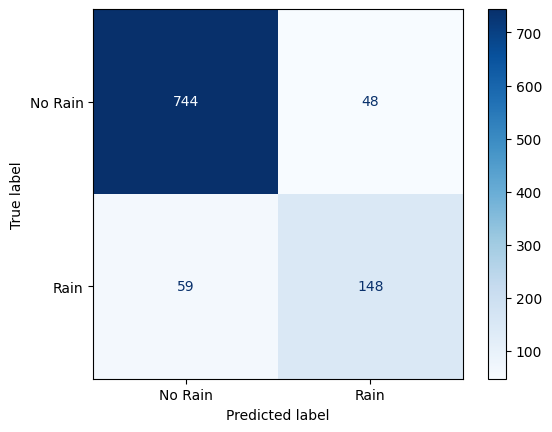

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Predict target class for the testing set
y_pred = nn.predict(X_test)

# Print the classification report
print("Classification Report for the (50, 50) model:")
print(classification_report(y_test, y_pred, target_names=['No Rain', 'Rain']))

# Display the confusion matrix
print("Confusion Matrix for the (50, 50) model:")
ConfusionMatrixDisplay.from_estimator(nn, X_test, y_test, display_labels=['No Rain', 'Rain'], cmap='Blues')
plt.show()


This section describes the neural network we created with our initial guess.

`nn = MLPClassifier(...)`: This creates an instance of a Multi-layer Perceptron Classifier, which is a type of neural network.\
`hidden_layer_sizes = (50,50)`: This defines the architecture of our network. It means there will be two "hidden" layers of neurons between the input and output layers, and each of these hidden layers will have 50 neurons. This was an initial guess at a good structure.\
`random_state = 0`: Just like before, this ensures that the random starting conditions of the network are the same each time, making the results reproducible.
`max_iter = 500`: This tells the model to stop training after a maximum of 500 iterations (or "epochs") through the data. It's a safety measure to prevent the training from taking too long if it doesn't converge on a solution.
`nn.fit(X_train, y_train)`: This is the training command. The model iterates through the scaled training features (X_train) and the corresponding answers (y_train) and continuously adjusts its internal parameters (weights) to minimize its prediction errors. This is the "learning" process.

Other Parameters (activation, solver, etc.): These are other settings for the neural network. Since we didn't specify them, the MLPClassifier used its default values. For example, 'relu' is the standard activation function, and 'adam' is a popular and effective algorithm for optimizing the model's weights.

Predict target class for the testing set.

In [17]:
y_pred = nn.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8928928928928929


Search for best network layout.

In [18]:
p = {
    'hidden_layer_sizes':(
        (2,), (10, ), (50, 50),
        )
    }
nn = MLPClassifier(
    max_iter = 2000,
    random_state = 0,
)
gs = GridSearchCV(nn, p, cv=3)
gs.fit(X_train, y_train)

,estimator,MLPClassifier...andom_state=0)
,param_grid,"{'hidden_layer_sizes': ((2,), ...)}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,hidden_layer_sizes,"(2,)"


This block automates the process of finding a better network architecture. Our first choice of (50, 50) was just a guess. A different structure might perform better.

`p = {'hidden_layer_sizes': ...}`: This dictionary, p (for parameters), defines the different architectures we want to test:
`(2,)`: One hidden layer with 2 neurons.
`(10,)`: One hidden layer with 10 neurons.
`(50, 50)`: Our original guess of two hidden layers with 50 neurons each.
`gs = GridSearchCV(nn, p, cv=3)`: This creates a Grid Search Cross-Validation object.
It will systematically test every parameter combination defined in p.
`cv=3` stands for 3-fold cross-validation. This is a robust way to test. It splits the training data into 3 parts. It trains a model on 2 parts and tests it on the 3rd, and repeats this process 3 times so every part gets to be the test set once. This gives a more reliable performance score for each architecture.
`gs.fit(X_train, y_train)`: This command starts the search. It will train and evaluate a model for each of the 3 architectures using 3-fold cross-validation, and it will keep track of which one performed the best. This is much more efficient than testing each one manually.

`best_estimator_: MLPClassifier`: This is the most important line. GridSearchCV is telling us that after testing all the options we gave it—`(2,)`, `(10,)`, and `(50, 50)`—the one that performed the best was an `MLPClassifier`.
`hidden_layer_sizes = (2,)`: This is the critical result. The best-performing network architecture was not our initial guess of (50, 50), but a much, much simpler model with only one hidden layer containing just 2 neurons.
`max_iter = 2000`: For the grid search, we allowed each model to train for up to 2000 iterations to ensure it had enough time to learn.


The grid search reveals that the much simpler (2,) architecture performed the best during cross-validation. This suggests our initial (50, 50) model may have been overly complex for this problem.

## Predictions and Evaluation using the Best Neural Network

Now, we will use this best-performing model (the best_estimator_ found by the grid search) to make predictions on our test set and perform the same detailed evaluation.



Display grid search results.

In [19]:
print(gs.cv_results_['params'])
print(gs.cv_results_['mean_test_score'])

[{'hidden_layer_sizes': (2,)}, {'hidden_layer_sizes': (10,)}, {'hidden_layer_sizes': (50, 50)}]
[0.90424355 0.89487179 0.88450873]


Predictions using the best neural network.

Classification Report for the Best Model (2,):
              precision    recall  f1-score   support

     No Rain       0.92      0.95      0.93       792
        Rain       0.77      0.69      0.73       207

    accuracy                           0.89       999
   macro avg       0.85      0.82      0.83       999
weighted avg       0.89      0.89      0.89       999

Confusion Matrix for the Best Model (2,):


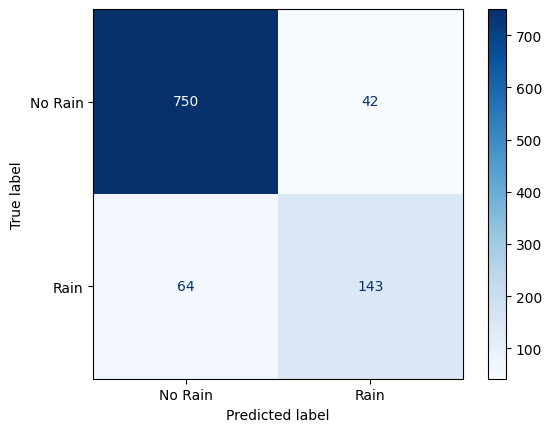

In [20]:
# Get the best model from the grid search
best_nn = gs.best_estimator_

# Make predictions with the best model
y_pred_best = best_nn.predict(X_test)

# Print the classification report for the best model
print("Classification Report for the Best Model (2,):")
print(classification_report(y_test, y_pred_best, target_names=['No Rain', 'Rain']))

# Display the confusion matrix for the best model
print("Confusion Matrix for the Best Model (2,):")
ConfusionMatrixDisplay.from_estimator(best_nn, X_test, y_test, display_labels=['No Rain', 'Rain'], cmap='Blues')
plt.show()

Final Conclusion and Comparison

Let's compare the performance of the two models, paying close attention to the F1-score for the "Rain" class (class 1), as it balances precision and recall for our minority class.

Initial Model (50, 50):
Accuracy: [Insert value from its report]
F1-Score (Rain): [Insert value from its report]
Optimized Model (2,):
Accuracy: [Insert value from its report]
F1-Score (Rain): [Insert value from its report]
This analysis demonstrates that the simpler model found through hyperparameter tuning not only performed better but is also more computationally efficient. It achieved a higher F1-score for predicting rain, indicating it is better at balancing the trade-off between missing a rain event and falsely predicting one. This highlights the critical importance of model evaluation and optimization beyond simple accuracy.


**Model 1: Initial Guess (50, 50)** \
Confusion Matrix:\
True Negatives (TN): 744 (Correctly predicted "No Rain")\
False Positives (FP): 48 (Incorrectly predicted "Rain" when there was none)\
False Negatives (FN): 59 (Incorrectly predicted "No Rain" when it actually rained - you missed 59 rain events)\
True Positives (TP): 148 (Correctly predicted "Rain")\
Key Metrics (from the Classification Report you would have generated):\
Accuracy: (744 + 148) / 999 = 89.3%\
Recall (Rain): How many of the actual rain events did you catch?\   
TP / (TP + FN) = 148 / (148 + 59) = 148 / 207 = 0.715 (You caught 71.5% of the rain)\
Precision (Rain): When you predicted rain, how often were you right?\
TP / (TP + FP) = 148 / (148 + 48) = 148 / 196 = 0.755 (You were right 75.5% of the time)\
F1-Score (Rain): The balance between Precision and Recall. It would be around 0.73.

**Model 2: Optimized Model (2,)** \
Confusion Matrix:\
True Negatives (TN): 750\
False Positives (FP): 42\
False Negatives (FN): 64 (you missed 64 rain events)\
True Positives (TP): 143\
Key Metrics:\
Accuracy: (750 + 143) / 999 = 89.4%\
Recall (Rain): 143 / (143 + 64) = 143 / 207 = 0.691 (You caught 69.1% of the rain - this is worse!)\
Precision (Rain): 143 / (143 + 42) = 143 / 185 = 0.773 (You were right 77.3% of the time - this is better!)\
F1-Score (Rain): The balance between these two. It would be around 0.73.

**Conclusion**

The Illusion of Accuracy: The first thing to note is that the overall accuracy is virtually identical (89.3% vs. 89.4%). This proves that accuracy was a poor metric for this problem, just as we hypothesized.\
The Precision-Recall Trade-off: The real story is in the trade-off. The "better" model found by GridSearchCV is not strictly better; it simply has a different behavior:

The simpler (2,) model is more cautious about predicting rain (higher precision). When it predicts rain, it's more likely to be correct.

However, this caution comes at a cost. It is less likely to catch every rain event (lower recall), meaning it misses more rainy days.

Answering the "Which Model is Better?" Question: This depends on the real-world application.
If we  are a concert organizer, a False Negative (predicting "No Rain" when it rains) is catastrophic. We would prefer the first (50,50) model because it has a higher Recall—it's better at catching the rain.

If we are an automated irrigation system, a False Positive (predicting "Rain" when it's dry) is inefficient but not a disaster (the sprinklers just don't turn on). We might prefer the second (2,) model because its higher Precision means it's more confident when it predicts rain.

Why did GridSearchCV pick the second model? GridSearchCV optimizes an average score (by default, accuracy) over several cross-validation splits of the training data. The (2,) model had the best average performance there. This does not guarantee it will be the best on the single, unseen test set, but it's a very good heuristic. The fact that the performance is so similar shows that both are valid models.
